In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv('../../preprocessing/apartments_preprocessed.csv')

In [4]:
df.head()
df['price'].describe()

count     9922.000000
mean      1481.016831
std        948.711174
min        200.000000
25%        949.000000
50%       1270.000000
75%       1695.000000
max      25000.000000
Name: price, dtype: float64

In [5]:
binovi = [199, 500, 1500, float('inf')]  # Definisanje granica stubica
ime_kategorija = ['Cheap/Affordable', 'Medium priced', 'Expensive']

df['price_category'] = pd.cut(df['price'], bins=binovi, labels=ime_kategorija, right=True)

In [6]:
# https://github.com/MATF-istrazivanje-podataka-1/materijali_2022-2023/blob/main/05/Najblizi_susedi.ipynb

from termcolor import colored
from sklearn.metrics import classification_report

def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    print("---------------------------------------------------------------------------------")

In [7]:
import pickle

with open('data.pkl', 'rb') as f:
    X_train, X_test, Y_train, Y_test = pickle.load(f)

In [8]:
# Inicijalizacija klasifikatora 
dtc = DecisionTreeClassifier(random_state=41)

# Treniranje
dtc.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=41)

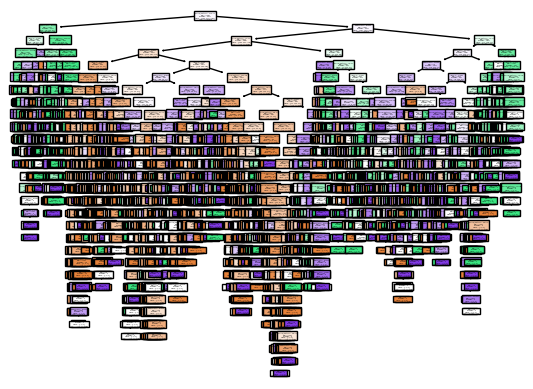

In [9]:
# Generisanje predikcije 
Y_pred = dtc.predict(X_test)

# Vizuelizacija
plt.figure()
plot_tree(dtc, feature_names=['bathrooms', 'bedrooms', 'square_meters','luxury','longitude','latitude'], class_names=ime_kategorija, filled=True)
plt.show()

In [10]:
report(dtc, X_train, Y_train)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.97      1.00      0.98      1925
       Expensive       0.99      1.00      0.99      2142
   Medium priced       0.99      0.96      0.98      2282

        accuracy                           0.98      6349
       macro avg       0.98      0.98      0.98      6349
    weighted avg       0.98      0.98      0.98      6349

---------------------------------------------------------------------------------


In [11]:
report(dtc, X_test, Y_test, "test")

Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.70      0.70      0.70       614
       Expensive       0.71      0.76      0.74       663
   Medium priced       0.58      0.55      0.56       708

        accuracy                           0.67      1985
       macro avg       0.67      0.67      0.67      1985
    weighted avg       0.66      0.67      0.66      1985

---------------------------------------------------------------------------------


<Axes: >

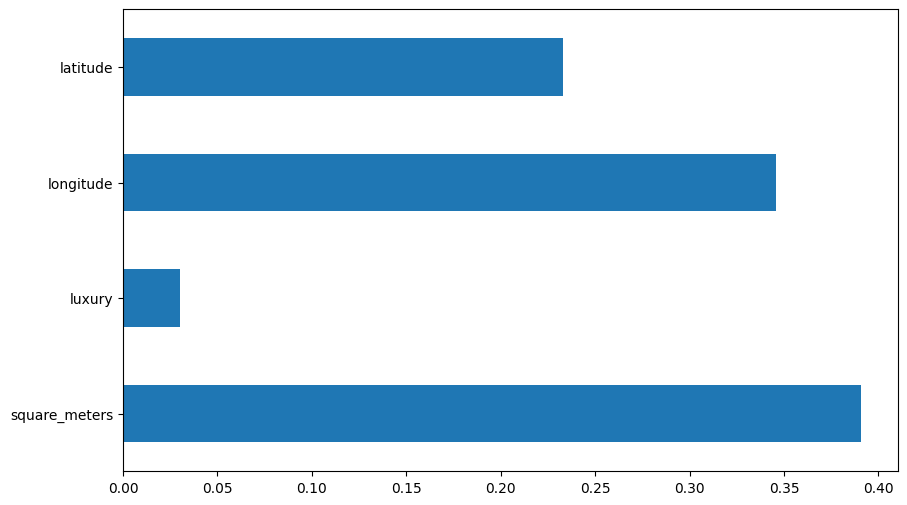

In [12]:
feat_importances = pd.Series(dtc.feature_importances_, index=X_train.columns)
feat_importances.plot(kind="barh",figsize=(10, 6))

Kriterijum 'luxury' ipak nije presudan u klasifikaciji, ali zato lokacija i kvadratura jesu.

# Matrica konfuzije

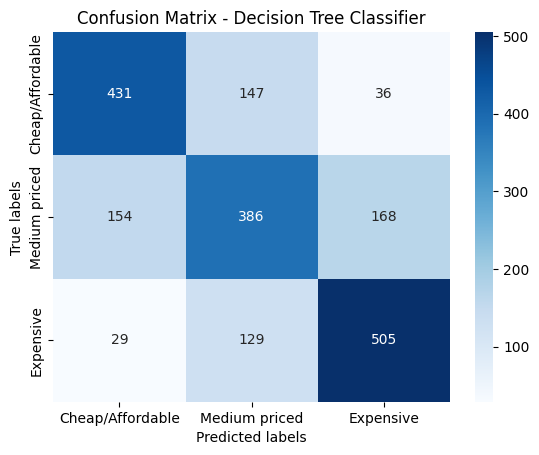

In [13]:
import seaborn as sns

cm = confusion_matrix(Y_test, Y_pred, labels=ime_kategorija)

# Heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=ime_kategorija, yticklabels=ime_kategorija)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Decision Tree Classifier')

plt.show()

# Optimizacija

In [15]:
from sklearn.model_selection import GridSearchCV

params = {
    'criterion': ['gini', 'entropy'],
    'max_depth':  range(5, 50, 5)
}

dtr_cv = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=params, cv=5)

In [16]:
# Prvi estimator ce balansirati klase tako sto ce podesavati tezine klasa obrnuto proporcionalno njihovim frekvencijama 
# u podacima. To znaci da ce algoritam dati vecu tezinu manjinskoj klasi i manju tezinu vecinskoj klasi.
GS_balanced_estimator = GridSearchCV(DecisionTreeClassifier(class_weight= 'balanced'), param_grid= params)

# Drugi estimator nece balansirati klase.
GS_estimator = GridSearchCV(DecisionTreeClassifier(), param_grid= params)


In [17]:
GS_balanced_estimator.fit(X_train, Y_train)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 50, 5)})

In [18]:
GS_balanced_estimator.best_params_

{'criterion': 'gini', 'max_depth': 15}

In [19]:
GS_balanced_estimator.best_score_

0.6801075929338619

In [20]:
report(GS_balanced_estimator.best_estimator_, X_train, Y_train)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.84      0.93      0.88      1925
       Expensive       0.96      0.93      0.95      2142
   Medium priced       0.89      0.85      0.87      2282

        accuracy                           0.90      6349
       macro avg       0.90      0.90      0.90      6349
    weighted avg       0.90      0.90      0.90      6349

---------------------------------------------------------------------------------


In [21]:
report(GS_balanced_estimator.best_estimator_, X_test, Y_test, "testing")

Classification report for model DecisionTreeClassifier on testing data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.69      0.75      0.72       614
       Expensive       0.74      0.76      0.75       663
   Medium priced       0.60      0.56      0.58       708

        accuracy                           0.68      1985
       macro avg       0.68      0.69      0.68      1985
    weighted avg       0.68      0.68      0.68      1985

---------------------------------------------------------------------------------


In [22]:
GS_estimator.fit(X_train, Y_train)
GS_estimator.best_params_
GS_estimator.best_score_
report(GS_estimator.best_estimator_, X_train, Y_train)
report(GS_estimator.best_estimator_, X_test, Y_test, "test")

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.86      0.92      0.89      1925
       Expensive       0.95      0.93      0.94      2142
   Medium priced       0.88      0.85      0.86      2282

        accuracy                           0.90      6349
       macro avg       0.90      0.90      0.90      6349
    weighted avg       0.90      0.90      0.90      6349

---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.70      0.72      0.71       614
       Expensive       0.72      0.77      0.74       663
   Medium priced       0.61   

Ukoliko je velika razlika u tacnosti kod trening i test skupa, znaci da se model preprilagodio.

# Optimizacija #2: Under-sampling -- NearMiss

NearMiss-1 bira instance većinske klase koje imaju najmanje srednje rastojanje od K najbližih instanci manjinske klase.
Deo koda preuzet: https://github.com/MATF-istrazivanje-podataka-1/materijali_2022-2023/blob/main/09/Rad_sa_nebalansiranim_klasama.ipynb

In [28]:
from imblearn.under_sampling import NearMiss

In [29]:
from collections import Counter
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
def resample(sampler, X, Y):
    X_resampled, y_resampled = sampler.fit_resample(X, Y)
    print(colored("Number of instances before resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(Y).items()), "green"))
    print(colored("Number of instances after  resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(y_resampled).items()), "blue"))
    return X_resampled, y_resampled

In [30]:
import numpy as np
def visualize(X, X_resampled, Y, Y_resampled, x_opacity=0.5):
    pca = PCA(n_components=2)
    pca.fit(X)
    
    X_pca = pca.transform(X)
    X_resampled_pca = pca.transform(X_resampled) 
    
    X_stacked = [X_pca, X_resampled_pca]
    Y_stacked = [Y, Y_resampled]
    
    fig = plt.figure(figsize=(20, 5))
    
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        unique_classes = np.unique(Y_stacked[i])
        colors = ['b' if y == unique_classes[0] else 'r' for y in Y_stacked[i]]
        alpha = [x_opacity if y == unique_classes[0] else 1 - x_opacity for y in Y_stacked[i]]
        plt.scatter(X_stacked[i][:, 0], X_stacked[i][:, 1], c=colors, alpha=alpha)
        plt.title('{} resampling'.format("After" if i else "Before"), c='blue' if i else 'green')
    plt.show()
    

In [35]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from termcolor import colored

def report_imbalanced(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report_imbalanced(y, y_pred, zero_division=True))
    print("---------------------------------------------------------------------------------")


In [36]:
def train_and_evaluate_model(X_train, Y_train, X_test, Y_test):
    model = DecisionTreeClassifier(max_depth=7, min_samples_split=25, criterion='gini')
    model.fit(X_train, Y_train)
    report_imbalanced(model, X_train, Y_train)
    report_imbalanced(model, X_test, Y_test)
    return model

Number of instances before resampling with NearMiss : dict_items([('Expensive', 2142), ('Cheap/Affordable', 1925), ('Medium priced', 2282)]). 
Number of instances after  resampling with NearMiss : dict_items([('Cheap/Affordable', 1925), ('Expensive', 1925), ('Medium priced', 1925)]). 


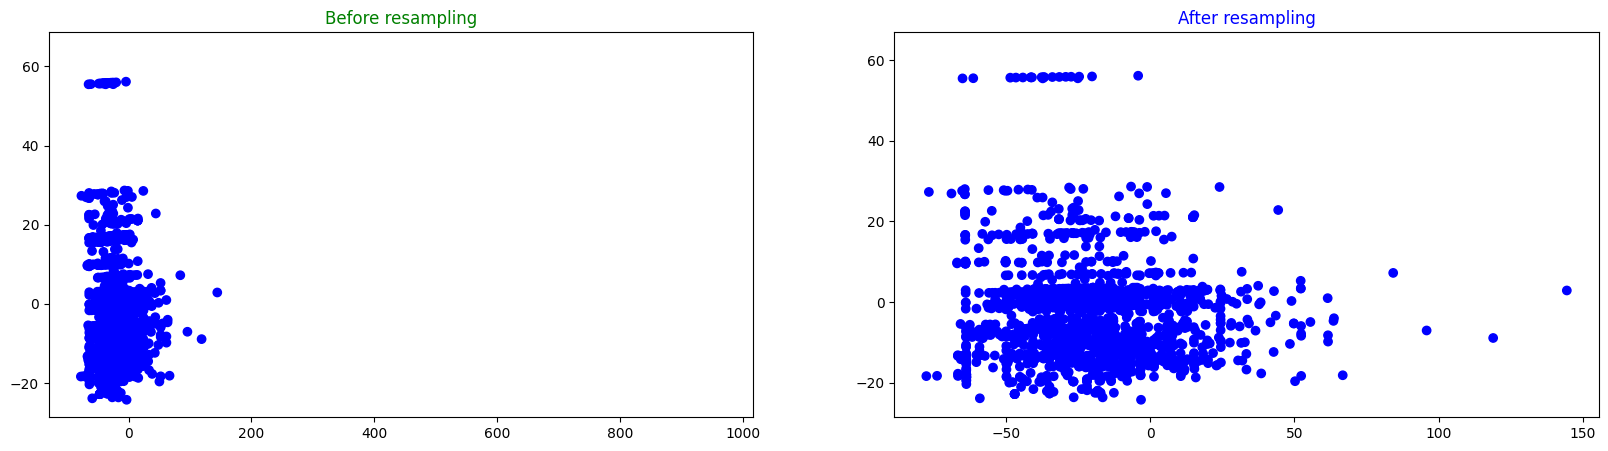

In [37]:
nm1 = NearMiss(version=1, n_neighbors=20)
X_resampled, y_resampled = resample(nm1, X_train, Y_train)
visualize(X_train, X_resampled, Y_train, y_resampled, 1)

In [38]:
model_nm1 = train_and_evaluate_model(X_resampled, y_resampled, X_test, Y_test)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                        pre       rec       spe        f1       geo       iba       sup

Cheap/Affordable       0.60      0.81      0.73      0.69      0.77      0.60      1925
       Expensive       0.85      0.74      0.93      0.79      0.83      0.68      1925
   Medium priced       0.61      0.48      0.85      0.54      0.64      0.39      1925

     avg / total       0.69      0.68      0.84      0.67      0.75      0.55      5775

---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                        pre       rec       spe        f1       geo       iba       sup

Cheap/Affordable       0.58      0.77      0.75      0.66      0.76      0.58 



NearMiss-2 bira instance većinske klase koje imaju najmanje srednje rastojanje od K najdaljih instanci manjinske klase.


Number of instances before resampling with NearMiss : dict_items([('Expensive', 2142), ('Cheap/Affordable', 1925), ('Medium priced', 2282)]). 
Number of instances after  resampling with NearMiss : dict_items([('Cheap/Affordable', 1925), ('Expensive', 1925), ('Medium priced', 1925)]). 


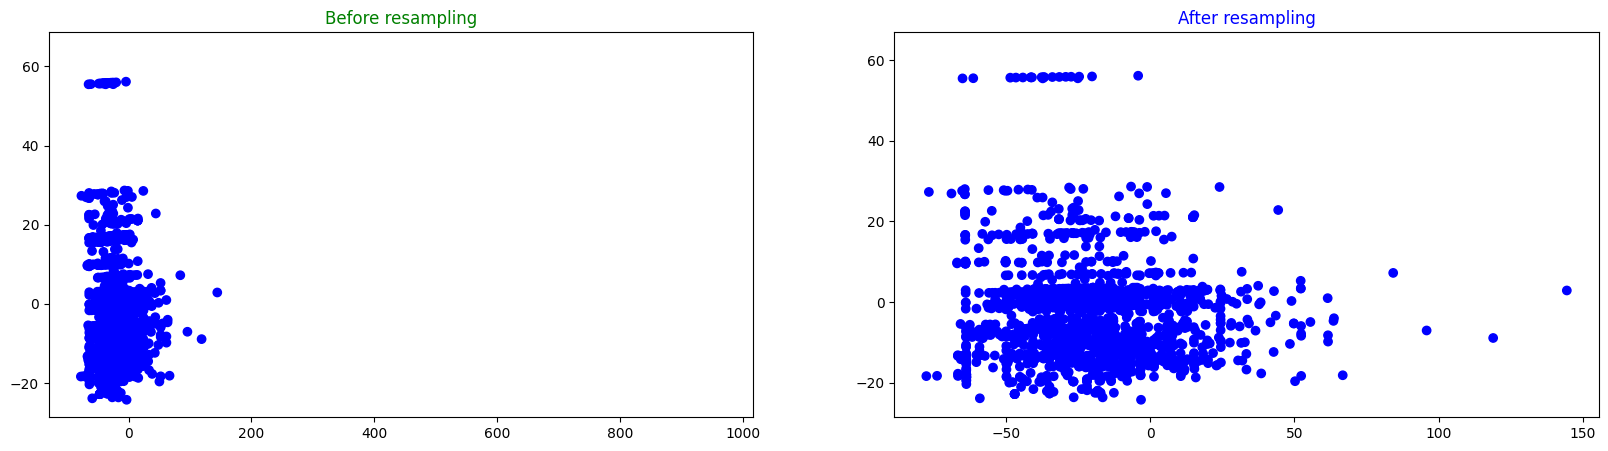

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                        pre       rec       spe        f1       geo       iba       sup

Cheap/Affordable       0.67      0.70      0.83      0.68      0.76      0.57      1925
       Expensive       0.84      0.75      0.93      0.79      0.83      0.68      1925
   Medium priced       0.58      0.63      0.78      0.60      0.70      0.48      1925

     avg / total       0.70      0.69      0.84      0.69      0.76      0.58      5775

---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
                        pre       rec       spe        f1       geo       iba       sup

Cheap/Affordable       0.60      0.69      0.80      0.64      0.74      0.54 

In [39]:
nm2 = NearMiss(version=2, n_neighbors=20)
X_resampled, y_resampled = resample(nm2, X_train, Y_train)
visualize(X_train, X_resampled, Y_train, y_resampled, 1)
model_nm2 = train_and_evaluate_model(X_resampled, y_resampled, X_test, Y_test)

# Optimizacija #3 -  RandomTreeForest

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
# Initialize the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=41)

# Train the model on the training set
rfc.fit(X_train, Y_train)

report(rfc, X_test, Y_test, "test")

Classification report for model RandomForestClassifier on test data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.74      0.74      0.74       614
       Expensive       0.76      0.79      0.78       663
   Medium priced       0.63      0.61      0.62       708

        accuracy                           0.71      1985
       macro avg       0.71      0.71      0.71      1985
    weighted avg       0.71      0.71      0.71      1985

---------------------------------------------------------------------------------


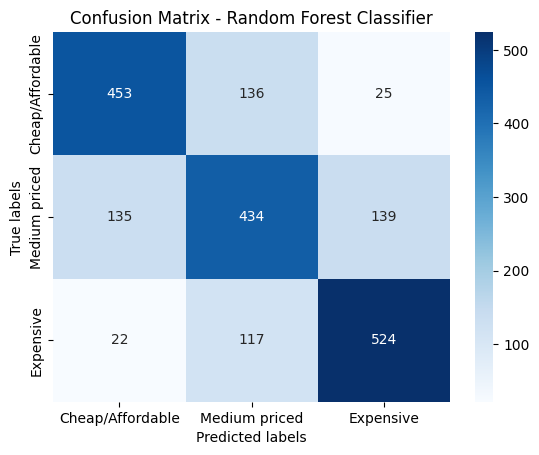

In [42]:
Y_pred = rfc.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(Y_test, Y_pred, labels=ime_kategorija)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=ime_kategorija, yticklabels=ime_kategorija)

# Add labels to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest Classifier')

plt.show()

In [43]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [50, 100, 200, 300]
}

estimator_rf = GridSearchCV(RandomForestClassifier(random_state=55), param_grid=params, cv=3)

In [44]:
estimator_rf.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=55),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [50, 100, 200, 300]})

In [45]:
estimator_rf.best_params_

{'criterion': 'entropy', 'n_estimators': 200}

In [46]:
estimator_rf.best_score_

0.7160184797416657

In [47]:
report(estimator_rf.best_estimator_, X_train, Y_train)

Classification report for model RandomForestClassifier on training data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.98      0.98      0.98      1925
       Expensive       0.99      0.99      0.99      2142
   Medium priced       0.98      0.98      0.98      2282

        accuracy                           0.98      6349
       macro avg       0.98      0.98      0.98      6349
    weighted avg       0.98      0.98      0.98      6349

---------------------------------------------------------------------------------


In [38]:
report(estimator_rf.best_estimator_, X_test, Y_test, "test")

Classification report for model RandomForestClassifier on test data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.74      0.73      0.74       614
       Expensive       0.77      0.80      0.78       663
   Medium priced       0.63      0.61      0.62       708

        accuracy                           0.71      1985
       macro avg       0.71      0.71      0.71      1985
    weighted avg       0.71      0.71      0.71      1985

---------------------------------------------------------------------------------
